In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Kinetic Ising Model simulation
Ising model with $N$ spins $\{-1,1\}$, cuplings matrix $J_{ij}$ and external field $h_i$. 

At each time step $\delta t$ each spin $s_i$ flips with a probability 
$$p_{flip} = \gamma \delta t \frac 1 2 [1-s_i(t)\tanh H_i(t)] \quad with \quad
H_i = h_i + \sum_{j \ne i} J_{ij}s_j(t)$$

In [6]:
class kinetic_ising:
    def __init__(self, N, J, h, gamma = 1):
        self.N = N
        self.J = np.copy(J)
        self.h = np.copy(h)
        self.S = -1*np.ones(N)
        self.H_i = np.dot(self.J,self.S)+self.h
        self.gamma = gamma
        self.history = np.copy(self.S)
    def comp_H(self):
        self.H_i = np.dot(self.J,self.S)+self.h
    
    def store(self):
        self.history = np.vstack((self.history,self.S))
    
    def update(self,dt):
        p = np.random.rand(N)
        p_up = dt*self.gamma*0.5*(1-self.S*np.tanh(self.H_i))
        #print(self.S)
        self.S[p < p_up] *= -1
        self.store()
        self.comp_H()
        
    def reset(self):
        self.S = -1*np.ones(N)
        self.history = np.copy(self.S)
    
    #if we put this func outside we can also use njit  
    def C(self,dt):
        # NB : in our case history[i,j] i is the time and j is the spin
        C = np.zeros((N,N))
        # since C is simmetric we can optimize it ... 
        for i in tqdm(range(N),desc='Computing C'):
            for j in range(N):
                C[i,j] = np.mean(self.history[:,i]*self.history[:,j])
        
        C_dot = np.zeros((N,N))
        for i in tqdm(range(N),desc='Computing C_dot'):
            for j in range(N):
                C_dot[i,j] = np.mean(self.history[1:,i]*self.history[:-1,j])
        
        C_dot -= C
        C_dot /= dt
        
        return C,C_dot
    
                

In [7]:
np.random.seed(123)
#number of spins
N = 5

#interactions matrix
mu = 0
sigma = 1
J = np.random.normal(mu,sigma,(N,N))
np.fill_diagonal(J,0) #j != i, 
#external field
mu = -0.2
sigma = 0.1
h = np.random.normal(mu,sigma,N)

gamma = 1
ising = kinetic_ising(N,J,h,gamma)

In [8]:
ising.reset()
np.random.seed(123)

time = 10
steps = 100_000
dt = time / steps
for i in tqdm(range(steps)):
    ising.update((dt))

100%|██████████| 100000/100000 [01:25<00:00, 1164.34it/s]


In [9]:
C,C_dot = ising.C(dt)

Computing C_dot: 100%|██████████| 5/5 [00:00<00:00, 406.64it/s]


In [10]:
print(C)

[[ 1.          0.24216758  0.09076909 -0.46916531 -0.32556674]
 [ 0.24216758  1.         -0.29894701  0.28866711  0.29818702]
 [ 0.09076909 -0.29894701  1.         -0.14132859 -0.23416766]
 [-0.46916531  0.28866711 -0.14132859  1.          0.56184438]
 [-0.32556674  0.29818702 -0.23416766  0.56184438  1.        ]]


Text(0.5, 1.0, 'Spin evlolution in time. [$s_i=1$ yellow, $s_i=-1$ blue]')

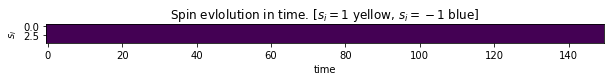

In [11]:
plt.figure(figsize=(10,10))
indcs = [i*10 for i in range(100)]
plt.imshow(ising.history.T[:,:150])
plt.xlabel('time')
plt.ylabel(r'$s_i$')
plt.title(r'Spin evlolution in time. [$s_i=1$ yellow, $s_i=-1$ blue]')


## Inference

### Equations

$$
\dot C_{ij} = \delta t ^{-1} \cdot [\langle s_i(t+\delta t)\cdot s_j(t) \rangle_{t} - C_{i,j}] \\
C_{ij} = \langle s_i(t)\cdot s_j(t) \rangle_{t} \\
L = \frac 1 {N_t} \sum_t\sum_i \Big[ h_i\cdot s_i(t) + \big[\sum_{j\ne i} J_{ij}\cdot (\gamma^{-1}\dot{C_{ij}} + C_{ij})\big] - \log \cosh H_i(t)\Big]
$$

<span style="color:blue">C'e' qualcosa di sbagliato in L, la cosa che mi turba maggiormente e' che i parametri "veri" utilizzati per generare i dati non massimizzano la funzione, ma manco vagamente. Un secondo problema e' che la L sembra essere non limitata :( .</span>

In [12]:
from scipy.optimize import minimize

def logcosh(x):
    #the funcion is even, the trick is to avoid e^x
    x = np.abs(x)
    return np.log(1/2) + x + np.log(1 + np.exp(-2*x))

def L(p,s,C,C_dot,gamma):
    steps = len(s)
    # p are the params, s is the spins history
    N = len(s[0])
    J = p[:N*N].reshape((N,N))     # NxN matrix
    h = p[N*N:]                    # N vector

    
    C_i = C_dot/gamma + C
    C_i = np.sum(C_i*J,axis = 1)
    
    L = 0
    for S in s: #for each time
        H_i = np.dot(J,S) + h 
        L += np.sum(-logcosh(H_i) + S*h + C_i)
    L /= steps
    return L

#versione ottimizzata della funzione (e' super piu veloce); sfrutta numpy e le matrici
def L_mat(p,s,C,C_dot,gamma):
    N_t = len(s)
    # p are the params, s is the spins history
    N = len(s[0])
    J_0 = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J_0,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                      # N vector

    #first term
    a_i = C_dot/gamma + C
    a_i = np.sum(a_i*J_0,axis = 1)   #sum over j    
    A = np.sum(a_i)
    
    #second term
    H = np.tile(h,(N_t,1))
    B = H + np.dot(s,J_0.T)
    B = -np.sum(logcosh(B))/N_t
    
    #third term
    C = np.dot(s,h)
    C = np.sum(C)/N_t
    #print(A,B,C)
    L = A + B + C
    return L

In [13]:
#little test
s_test = np.array([[1,1],[1,1],[1,-1]])
h_test = np.array([0.5,-0.5])
J_test = np.array([[0,1],[2,0]])
C_dot_test = np.array([[-2,0.5],[0.5,-2]])
C_test = np.array([[1,0.5],[0.5,1]])
p_test = np.concatenate((J_test.flatten(),h_test))
L_mat(p_test,s_test,C_test,C_dot_test,1)

1.8675615459909132

Ho confrontato i risultati con dei calcoli fatti a mano, il problema e' che il risultato sembra coincidere.

## Maximization using scipy (non funzia)

In [14]:
#bounds = [(-3,3) for i in range(N*N+N)]

p_real = np.concatenate((J.flatten(),h))
#p_0 = np.random.normal(0,0.1,N*N+N)
#p_0 = np.ones(N*N+N)
#p_inf = minimize(L_mat,p_0,args=(ising.history,C,C_dot,gamma)).x

In [15]:
#L_mat(p_inf,ising.history,C,C_dot,gamma)

In [16]:
#L(p_real,ising.history,C,C_dot,gamma)

### Gradinent
$$
\frac {\partial L}{\partial h_i} = \langle s_i(t) - \tanh{H_i(t)} \rangle_t \\
\frac {\partial L}{\partial J_{ij}} = \gamma ^ {-1} \dot{C_{ij}} + C_{ij} - \langle \tanh{H_i(t)}s_j(t)  \rangle_t
$$

In [17]:
def L_grad(p,s,C,C_dot,gamma):
    N_t = len(s)
    # p are the params, s is the spins history
    N = len(s[0])
    J_0 = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J_0,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                      # N vector

    dh = np.tile(h,(N_t,1))
    dh = dh + np.dot(s,J_0.T)
    dh = s - np.tanh(dh)
    dh = np.mean(dh,axis=0)
    # lambda
    
    dJ = C_dot/gamma + C
    O = np.zeros((N,N))
    
    #has to be optimized better
    for S in s:
        H_i = np.tanh(h + np.dot(J_0,S))
        O += np.outer(H_i,S)
    O /= N_t
    dJ -= O
    
    return np.concatenate((dJ.flatten(),dh))

# Test
We compute by hand the partial derivative with respect a single parameter and we confront it with the value computed by the analytic formula

In [18]:
param = 14

x = np.ones(N*N + N) + 10
dx = 0.00001
print(L_grad(x,ising.history,C,C_dot,gamma)[param])
y_i = L_mat(x,ising.history,C,C_dot,gamma)
x[param]+=dx
y_f = L_mat(x,ising.history,C,C_dot,gamma)
print((y_f-y_i)/dx)

-0.7923880760880658
-0.7923880744442612


## Optimization

### SGA

In [19]:
np.random.seed(201098)
mu = -0.2
sigma = 0.1
x_0 = 1+np.zeros(N*N+N)

steps = 1000
l_r = 0.1

LAMBDA = 0
L_list = [L_mat(x_0,ising.history,C,C_dot,gamma)] 
for i in tqdm(range(steps),desc = 'Optimizing'):
    x_0 += l_r * (L_grad(x_0,ising.history,C,C_dot,gamma) - LAMBDA * np.sign(x_0))
    L_list.append(L_mat(x_0,ising.history,C,C_dot,gamma))
    #if L_list[-2] > L_list[-1]: break 
plt.plot(L_list)

Optimizing:  41%|████▏     | 414/1000 [08:33<12:06,  1.24s/it]


KeyboardInterrupt: 

In [ ]:
plt.imshow([x_0])

In [ ]:
plt.imshow([p_real])

In [ ]:
for (i,j) in zip(x_0,p_real):
    print(i,j)

The functions doesn't have a upper limit and so goes to ininity linearly (indipendently on N)

## SGA mom

In [ ]:
x_0 = np.zeros(N*N+N)
v_0 = np.zeros(N*N+N)

steps = 1000
eta = 1        #learning rate
zeta = 0.3     #friction
LAMBDA = 0.2   #penalty

L_list = [L_mat(x_0,ising.history,C,C_dot,gamma)] 

for i in tqdm(range(1,steps),desc = 'Optimizing'):
    v_0 = zeta*v_0 + eta/i * (L_grad(x_0,ising.history,C,C_dot,gamma) - LAMBDA * np.sign(x_0))
    x_0 += v_0
    L_list.append(L_mat(x_0,ising.history,C,C_dot,gamma))
    
plt.plot(L_list)

In [ ]:
plt.imshow([x_0])

In [ ]:
plt.imshow([p_real])

In [ ]:
plt.imshow([x_0,p_real])

In [ ]:
plt.figure(figsize = (9,9))
for dim in range(30):
    x = 2+ np.zeros(N*N + N)
    L = []
    for i in range(100):
        L.append(L_mat(x,ising.history,C,C_dot,gamma))
        x[dim] -= 0.2

    plt.plot(L,label = dim)
plt.legend()